# Exploration of factors influencing students’ PISA scores in Thailand with Machine Learning approaches : Classification Models 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import xgboost as xg 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression


# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report

#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

# Feature Importance 
import shap

In [2]:
#Import datasets
train_thailand = pd.read_csv('datasets/train_pisa2018_thailand.csv')
test_thailand = pd.read_csv('datasets/test_pisa2018_thailand.csv')

In [3]:
train_thailand.head(2)

CNTSTUID  GRADE    AGE         ISCEDL   ISCEDO  PARED   IMMIG  \
0  76400082.0    0.0  15.75  ISCED level 3  General   12.0  Native   
1  76401146.0   -1.0  15.42  ISCED level 2  General    6.0  Native   

                    REPEAT  MMINS  LMINS  ...  CLSIZE CREACTIV  EDUSHORT  \
0  Did not repeat a  grade  240.0  240.0  ...      33        2    1.2478   
1  Did not repeat a  grade  200.0  150.0  ...      33        3   -1.4212   

   STAFFSHORT  STUBEHA  TEACHBEHA  SCMCEG  Is_MISCED_5A,6  Is_FISCED_5A,6  \
0      0.1077   0.1795    -0.5205 -1.0542               0               0   
1     -1.4551  -3.3785    -0.7624 -0.1868               0               0   

   Is_HISCED_5A,6  
0               0  
1               0  

[2 rows x 95 columns]

In [4]:
test_thailand.head(2)

CNTSTUID  GRADE    AGE         ISCEDL   ISCEDO  PARED   IMMIG  \
0  76406643.0    0.0  15.42  ISCED level 3  General   16.0  Native   
1  76407714.0    0.0  15.67  ISCED level 3  General   12.0  Native   

                    REPEAT  MMINS  LMINS  ...  CLSIZE CREACTIV  EDUSHORT  \
0  Did not repeat a  grade   50.0  100.0  ...      48        3   -0.1130   
1  Did not repeat a  grade  110.0  330.0  ...      43        2    2.1432   

   STAFFSHORT  STUBEHA  TEACHBEHA  SCMCEG  Is_MISCED_5A,6  Is_FISCED_5A,6  \
0     -0.2968  -0.0384     0.9229 -1.4469               1               1   
1     -0.4314   0.2268    -2.0409 -0.1868               0               0   

   Is_HISCED_5A,6  
0               1  
1               0  

[2 rows x 95 columns]

In [5]:
#Check for missing values
train_thailand.isnull().sum().sum(), test_thailand.isnull().sum().sum()

(0, 0)

In [6]:
#Set 'CNTSTUID' as index
train_thailand.set_index('CNTSTUID', inplace=True)
test_thailand.set_index('CNTSTUID', inplace=True)

In [7]:
train_thailand[['TOTALSCORE']].describe()

TOTALSCORE
count  6775.000000
mean    431.946357
std      85.666985
min     210.007233
25%     367.618350
50%     419.663433
75%     489.412667
max     707.016300

## Creating target variable

Classify students' performance level based on their Pisa total score. 
OECD classify student's performance level into 6 levels.
Higher than 707.93 ==> level 6
633.33-707.93 ==> level 5
558.73 - 633.33 ==> level 4
484.14 - 558.73 ==> level 3
409.54 - 484.14 ==> level 2
lower than 409.54  ==> level 1

In this analysis, student's perfomance are classified into two groups, level 3 and above or level 2 and below. 

In [8]:
# Create funtion to classify student's performance
def assign_performance_level(data):
    if data <= 484.14:
        return '0' #lowperformance 
    else:
         return '1'  #highperformance 

In [9]:
#Apply function to data
train_thailand['PISALEVEL'] = train_thailand['TOTALSCORE'].apply(assign_performance_level)
test_thailand['PISALEVEL'] = test_thailand['TOTALSCORE'].apply(assign_performance_level)

In [10]:
#Check target distribution
train_thailand['PISALEVEL'].value_counts()

0    4975
1    1800
Name: PISALEVEL, dtype: int64

In [11]:
#Check target distribution
train_thailand['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    73.43
1    26.57
Name: PISALEVEL, dtype: float64

In [12]:
#Check target distribution
test_thailand['PISALEVEL'].value_counts()

0    1286
1     441
Name: PISALEVEL, dtype: int64

In [13]:
#Check target distribution
test_thailand['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    74.46
1    25.54
Name: PISALEVEL, dtype: float64

# Building Classification Models

In [14]:
# X and y are defined as same as regression model from previous study

In [15]:
X_train =train_thailand[['GRADE', 'PARED', 'SMINS', 'CHANGE', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'EMOSUPS', 'JOYREAD',
       'WORKMAST', 'GCSELFEFF', 'PERSPECT', 'RESPECT', 'AWACOM',
       'DISCRIM', 'INTICT',  'STRATIO', 'TOTAT', 'PROAT5AB', 'PROAT5AM', 'PROAT6',
       'CREACTIV','EDUSHORT', 'STUBEHA', 'Is_MISCED_5A,6', 'Is_FISCED_5A,6',
       'Is_HISCED_5A,6', 'ISCEDL','ISCEDO', 'IMMIG', 'REPEAT', 'SCCHANGE', 'GENDER','SCHLTYPE']]
X_train = pd.get_dummies(columns=['Is_MISCED_5A,6', 'Is_FISCED_5A,6','Is_HISCED_5A,6', 'ISCEDL','ISCEDO', 
                                  'IMMIG', 'REPEAT', 'SCCHANGE', 'GENDER','SCHLTYPE'], drop_first =True, data =X_train)
y_train = train_thailand['PISALEVEL']


X_test =test_thailand[['GRADE', 'PARED', 'SMINS', 'CHANGE', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'EMOSUPS', 'JOYREAD',
       'WORKMAST', 'GCSELFEFF', 'PERSPECT', 'RESPECT', 'AWACOM',
       'DISCRIM', 'INTICT',  'STRATIO', 'TOTAT', 'PROAT5AB', 'PROAT5AM', 'PROAT6',
       'CREACTIV','EDUSHORT', 'STUBEHA', 'Is_MISCED_5A,6', 'Is_FISCED_5A,6',
       'Is_HISCED_5A,6', 'ISCEDL','ISCEDO', 'IMMIG', 'REPEAT', 'SCCHANGE', 'GENDER','SCHLTYPE']]
X_test = pd.get_dummies(columns=['Is_MISCED_5A,6', 'Is_FISCED_5A,6','Is_HISCED_5A,6', 'ISCEDL','ISCEDO', 
                                  'IMMIG', 'REPEAT', 'SCCHANGE', 'GENDER','SCHLTYPE'], drop_first =True, data =X_test)
y_test = test_thailand['PISALEVEL']

## Dummy Classifier model

In [16]:
#Standardize data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

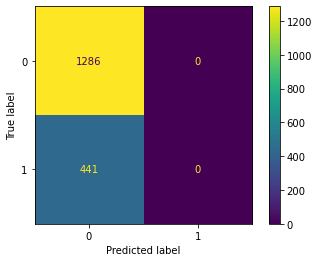

In [17]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier()
baseline_model.fit(X_train_sc, y_train)
baseline_preds = baseline_model.predict(X_test_sc)
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds);

In [18]:
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test, baseline_preds))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1286
           1       0.00      0.00      0.00       441

    accuracy                           0.74      1727
   macro avg       0.37      0.50      0.43      1727
weighted avg       0.55      0.74      0.64      1727



## Logistic Regression

In [19]:
logreg =LogisticRegression()


parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 100]}]

logreg_gr = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

logreg_gr.fit(X_train_sc, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['none', 'l2']}, {'C': [1, 10, 100]}],
             scoring='accuracy')

In [20]:
preds= logreg_gr.predict(X_test_sc)

In [21]:
pd.DataFrame(logreg_gr.cv_results_).sort_values('rank_test_score').head(5)[['params','mean_test_score']]

params  mean_test_score
0  {'penalty': 'none'}         0.884428
3            {'C': 10}         0.884428
4           {'C': 100}         0.884428
1    {'penalty': 'l2'}         0.884133
2             {'C': 1}         0.884133

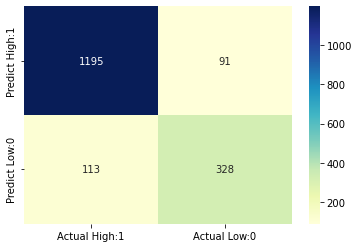

In [22]:
cm = confusion_matrix(y_test, preds)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [23]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1286
           1       0.78      0.74      0.76       441

    accuracy                           0.88      1727
   macro avg       0.85      0.84      0.84      1727
weighted avg       0.88      0.88      0.88      1727



In [24]:
#Get LogisticRegression
logreg =LogisticRegression(random_state= 42,)
logreg.fit(X_train_sc, y_train)
preds= logreg.predict(X_test_sc)
pd.Series(logreg.coef_[0], index = X_train.columns).sort_values(ascending=False)

GRADE                           0.487511
ESCS                            0.484564
METASUM                         0.406086
SMINS                           0.363276
RESPECT                         0.361071
METASPAM                        0.329969
UNDREM                          0.302304
PROAT6                          0.253936
TOTAT                           0.242267
HEDRES                          0.235223
Is_HISCED_5A,6_1                0.230777
ICTRES                          0.217050
GCSELFEFF                       0.201257
INTICT                          0.184267
CREACTIV                        0.183727
JOYREAD                         0.117427
PERSPECT                        0.104211
Is_FISCED_5A,6_1                0.096805
Is_MISCED_5A,6_1                0.074620
SCCHANGE_one change             0.030344
AWACOM                          0.023049
SCHLTYPE_3                      0.021526
IMMIG_Second-Generation        -0.011001
SCCHANGE_two or more changes   -0.023104
WORKMAST        

In [25]:
# coefficient dataframe
logreg_coef = pd.DataFrame(data=logreg.coef_,columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in logreg_coef[0]]

# Assign the color_list to new column
logreg_coef['color'] = color

logreg_coef.head()

0 color
GRADE    0.487511  blue
ESCS     0.484564  blue
METASUM  0.406086  blue
SMINS    0.363276  blue
RESPECT  0.361071  blue

In [26]:
# Select the highest values whether negative or positive
abs(logreg_coef[0]).sort_values(ascending=False)[:10].index

Index(['STUBEHA', 'GRADE', 'ESCS', 'ISCEDO_Vocational', 'METASUM', 'CHANGE',
       'DISCRIM', 'SMINS', 'RESPECT', 'METASPAM'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

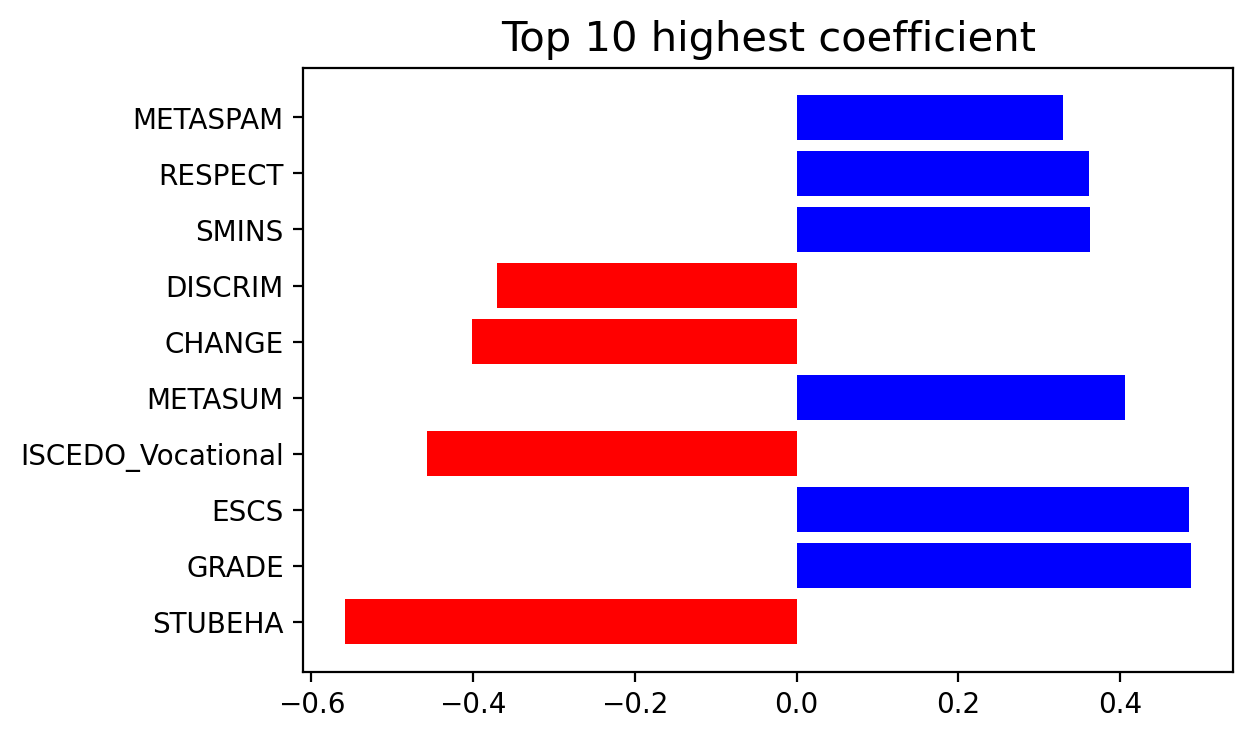

In [27]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(logreg_coef.loc[['STUBEHA', 'GRADE', 'ESCS', 'ISCEDO_Vocational', 'METASUM', 'CHANGE',
       'DISCRIM', 'SMINS', 'RESPECT', 'METASPAM']].index,logreg_coef.loc[['STUBEHA', 'GRADE', 'ESCS', 'ISCEDO_Vocational', 'METASUM', 'CHANGE',
       'DISCRIM', 'SMINS', 'RESPECT', 'METASPAM']][0],color=logreg_coef.loc[['STUBEHA', 'GRADE', 'ESCS', 'ISCEDO_Vocational', 'METASUM', 'CHANGE',
       'DISCRIM', 'SMINS', 'RESPECT', 'METASPAM']]['color'])
plt.title('Top 10 highest coefficient',size=15)

## Explainable Boosting Classifier model

In [28]:
ebm = ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['GRADE', 'PARED', 'SMINS',
                                             'CHANGE', 'ESCS', 'UNDREM',
                                             'METASUM', 'METASPAM', 'HOMEPOS',
                                             'HEDRES', 'ICTRES', 'EMOSUPS',
                                             'JOYREAD', 'WORKMAST', 'GCSELFEFF',
                                             'PERSPECT', 'RESPECT', 'AWACOM',
                                             'DISCRIM', 'INTICT', 'STRATIO',
                                             'TOTAT', 'PROAT5AB', 'PROAT5AM',
                                             'PROAT6', 'CREACTIV', 'EDUSHORT',
                                             'STUBEHA', 'Is_MISCED_5A,6_1',
                                             'Is_FISCED_5A,6...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'categorical', 'categorical', ...])

In [29]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [30]:
ebm.score(X_train, y_train),ebm.score(X_test, y_test)

(0.9217712177121771, 0.8922987840185292)

In [31]:
preds_ebm = ebm.predict(X_test)

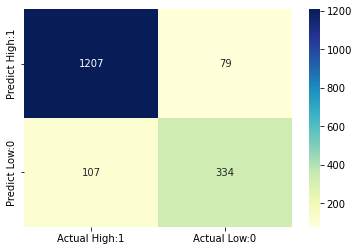

In [32]:
cm_ebm = confusion_matrix(y_test, preds_ebm)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [33]:
print(classification_report(y_test, preds_ebm))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1286
           1       0.81      0.76      0.78       441

    accuracy                           0.89      1727
   macro avg       0.86      0.85      0.86      1727
weighted avg       0.89      0.89      0.89      1727



## Random Forest Classifier Model

In [34]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

rfc.fit(X_train, y_train)

# Predict on the test set results

preds_rfc = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. 
      format(accuracy_score(y_test, preds)))

Model accuracy score with 100 decision-trees : 0.8819


In [35]:
#Find important features with Random Forest model 

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

ESCS                            0.089086
SMINS                           0.079735
HOMEPOS                         0.068052
STUBEHA                         0.056741
ICTRES                          0.048367
METASUM                         0.038773
RESPECT                         0.037766
EDUSHORT                        0.033961
HEDRES                          0.033394
JOYREAD                         0.033185
PARED                           0.032883
TOTAT                           0.031996
STRATIO                         0.031630
DISCRIM                         0.030489
PROAT5AB                        0.029840
Is_HISCED_5A,6_1                0.028728
PERSPECT                        0.027928
PROAT6                          0.026769
UNDREM                          0.026467
GCSELFEFF                       0.025941
INTICT                          0.025613
PROAT5AM                        0.024172
AWACOM                          0.020965
METASPAM                        0.020414
WORKMAST        

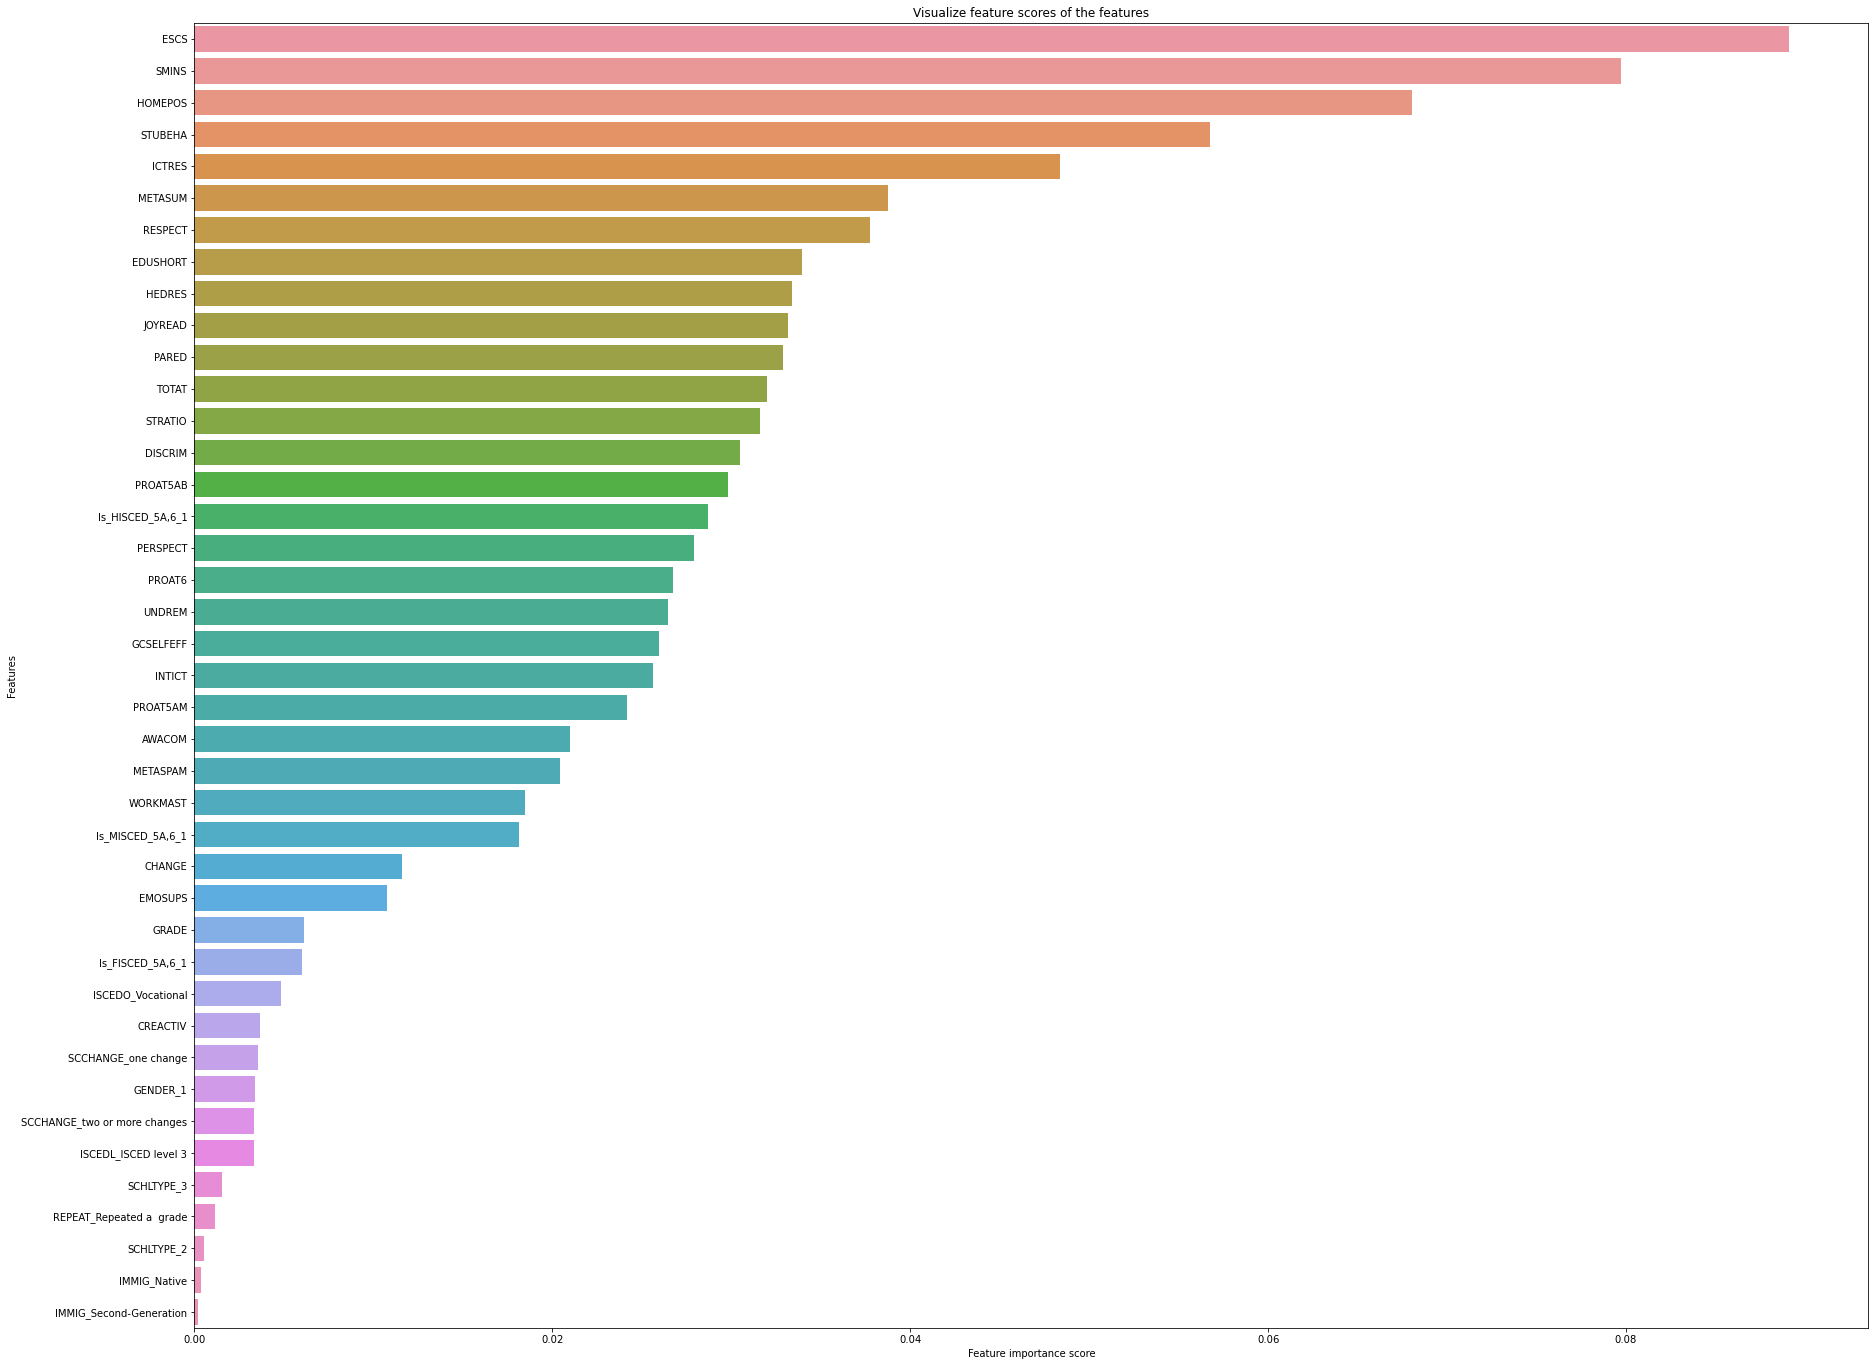

In [36]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train_thailand)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

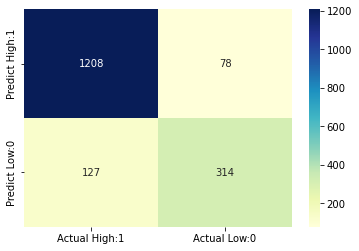

In [37]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_rfc, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [38]:
print(classification_report(y_test, preds_rfc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1286
           1       0.80      0.71      0.75       441

    accuracy                           0.88      1727
   macro avg       0.85      0.83      0.84      1727
weighted avg       0.88      0.88      0.88      1727



# XGB Classifier model

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [40]:
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 4)
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [41]:
preds_xgb = xgb.predict(X_test_sc)

In [42]:
# view the feature scores

feature_scores = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

ESCS                            0.086670
ISCEDO_Vocational               0.071639
STUBEHA                         0.061300
SMINS                           0.054340
METASUM                         0.047575
RESPECT                         0.045407
SCHLTYPE_2                      0.043250
CHANGE                          0.040406
HEDRES                          0.034431
SCHLTYPE_3                      0.033513
EDUSHORT                        0.028153
PROAT5AB                        0.028106
DISCRIM                         0.027535
METASPAM                        0.026729
Is_FISCED_5A,6_1                0.025272
TOTAT                           0.023589
GRADE                           0.021568
STRATIO                         0.020104
UNDREM                          0.019680
CREACTIV                        0.019667
PROAT6                          0.018177
ICTRES                          0.017084
PERSPECT                        0.016774
INTICT                          0.016596
PROAT5AM        

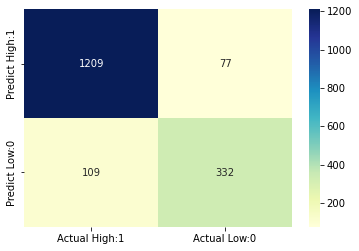

In [43]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_xgb, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [44]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1286
           1       0.81      0.75      0.78       441

    accuracy                           0.89      1727
   macro avg       0.86      0.85      0.85      1727
weighted avg       0.89      0.89      0.89      1727



In [45]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_sc)

In [46]:
shap_values

array([[-6.02116529e-03, -2.99553107e-02,  5.42484283e-01, ...,
        -1.72996446e-01,  7.39822537e-03, -1.07526239e-02],
       [-1.96166381e-01, -3.94031882e-01, -1.20864344e+00, ...,
        -1.50942072e-01,  1.30454181e-02, -4.20428924e-02],
       [-1.70031264e-02, -6.65293336e-02, -1.08859158e+00, ...,
        -9.68445912e-02,  1.22637674e-02, -1.11053465e-02],
       ...,
       [-3.02257780e-02, -2.64795274e-02,  9.39192235e-01, ...,
         1.43469915e-01,  1.22637674e-02, -1.03110904e-02],
       [ 1.36070192e+00,  4.18311823e-03,  1.24411547e+00, ...,
         1.12250298e-01,  1.21270772e-04, -6.22699549e-03],
       [-4.78323363e-02, -1.01140141e-01, -5.21421790e-01, ...,
        -2.93896534e-03,  1.14340344e-02,  3.57393399e-02]], dtype=float32)

In [52]:
#Local explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[0,:])

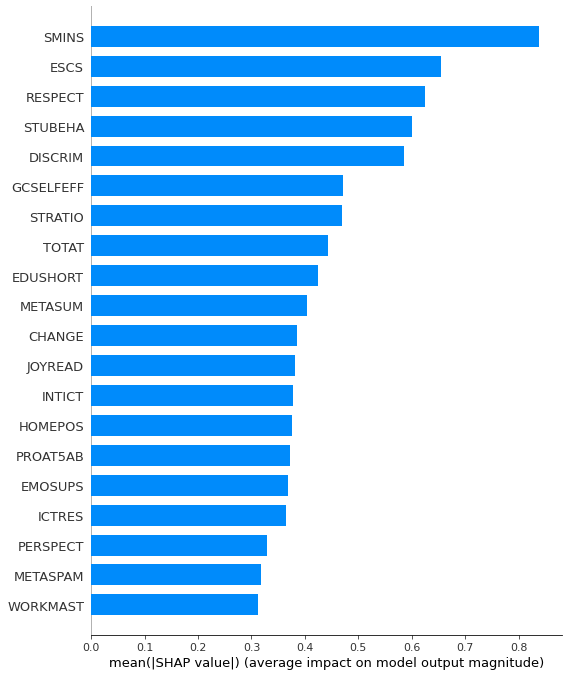

In [49]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names= X_train.columns)

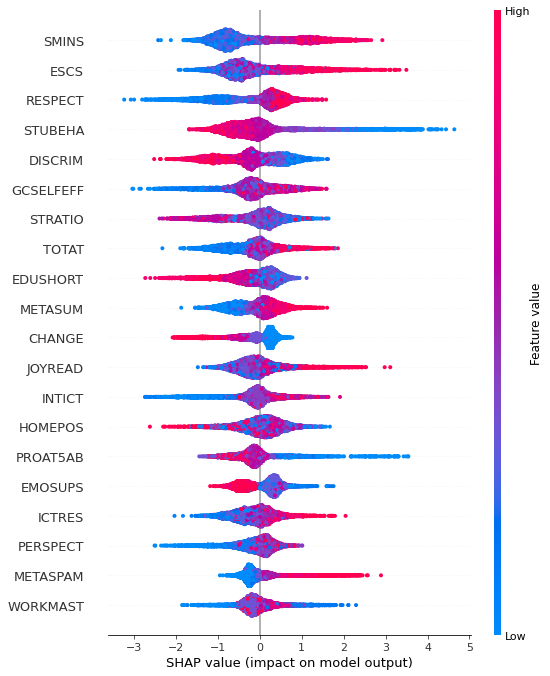

In [50]:
shap.summary_plot(shap_values, X_train)

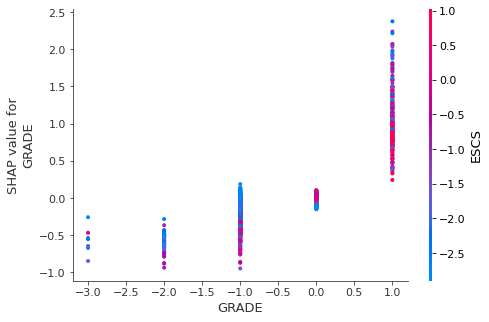

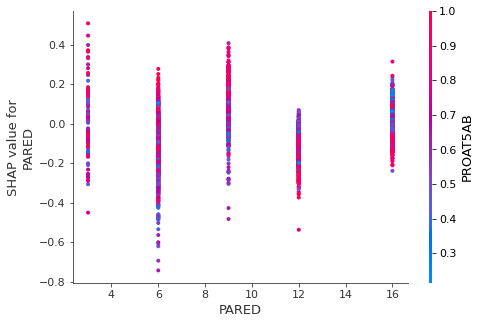

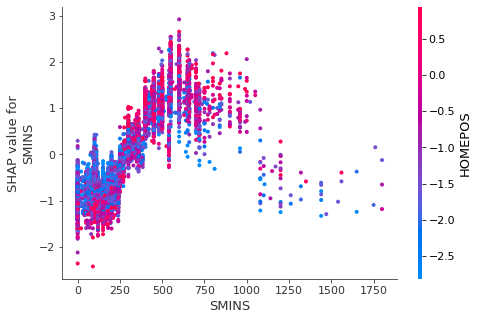

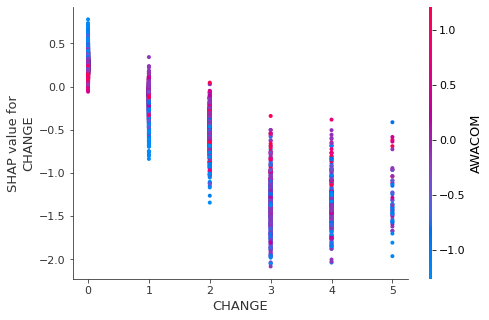

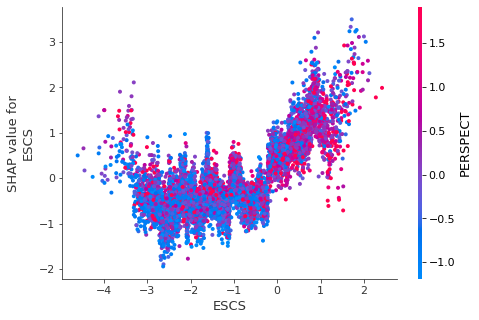

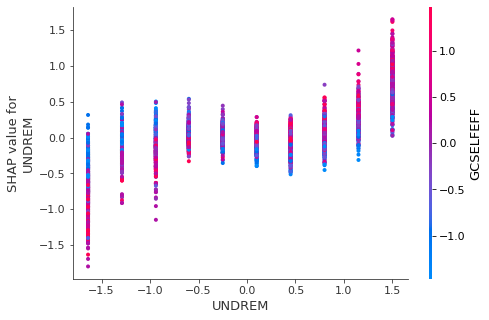

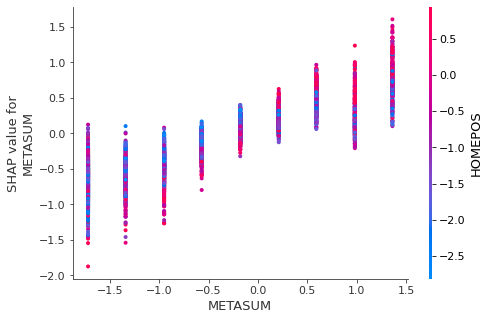

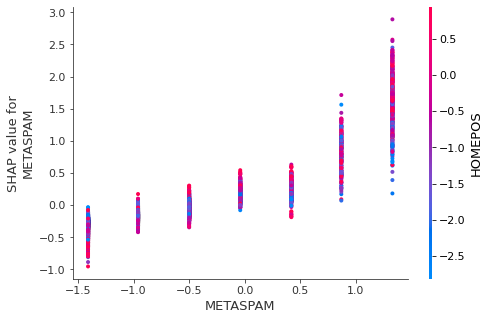

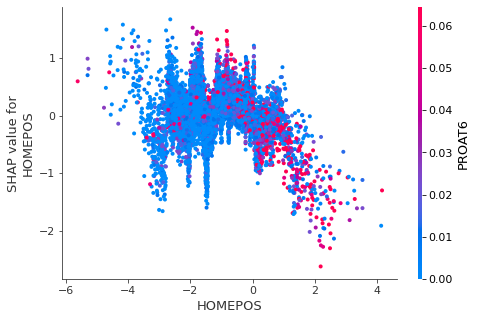

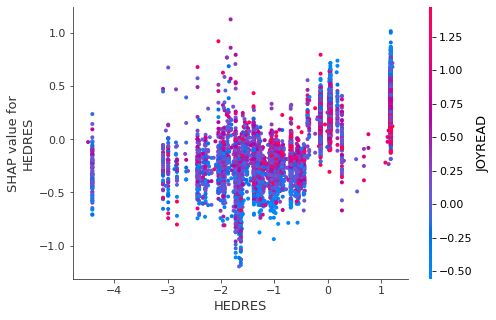

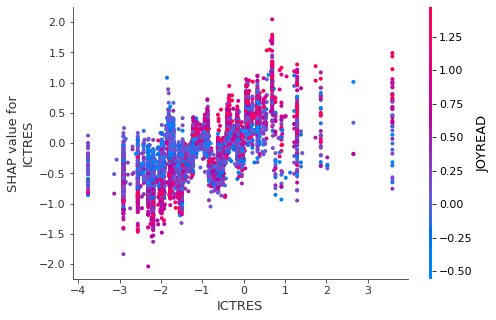

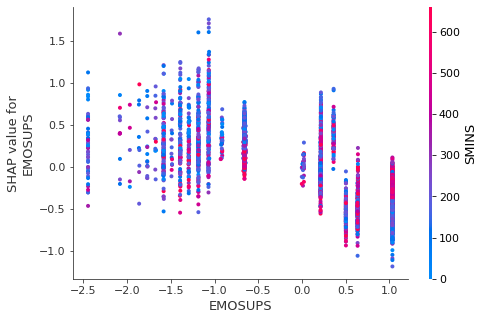

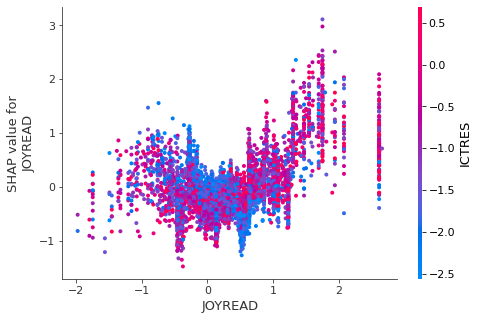

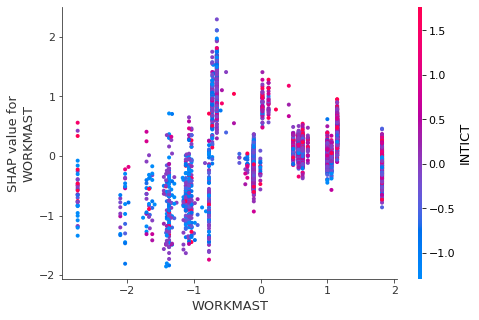

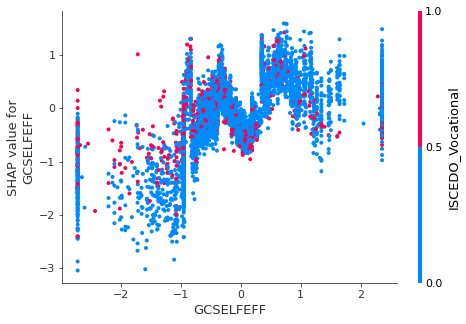

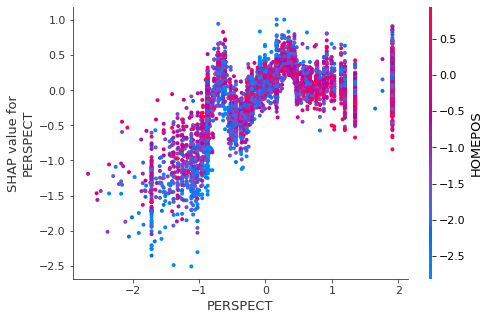

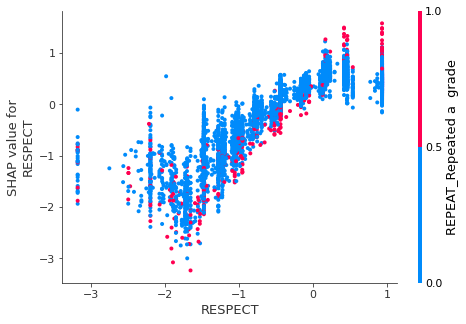

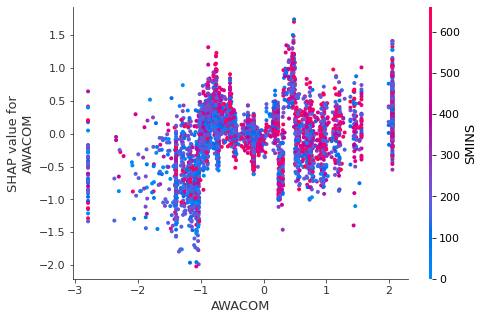

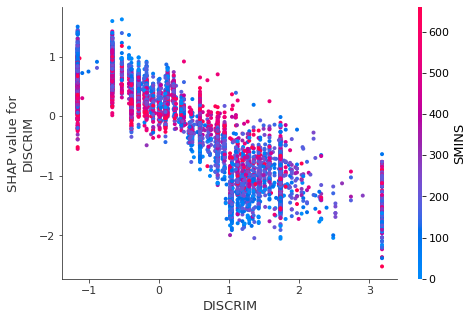

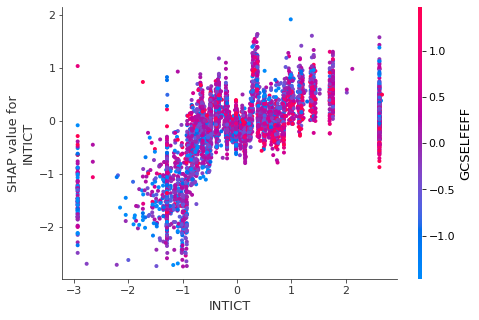

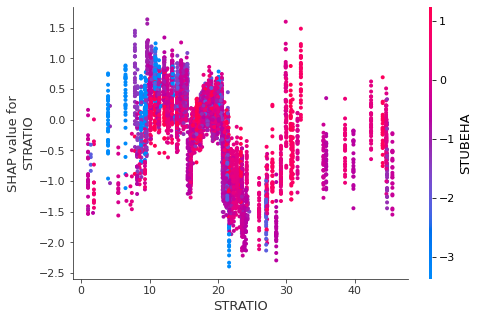

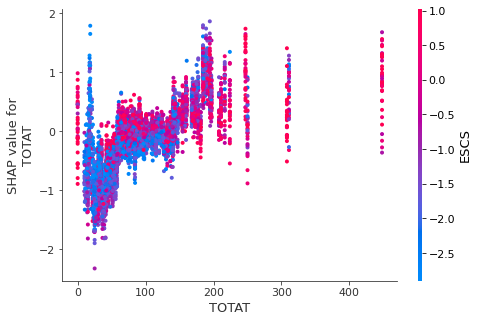

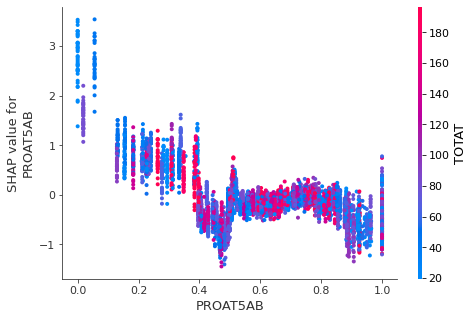

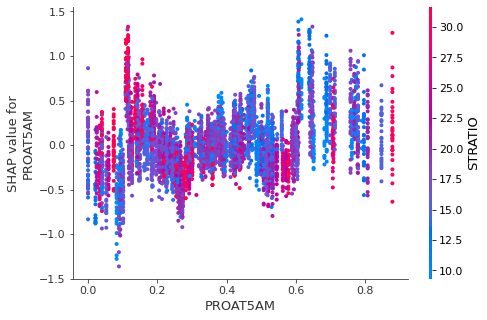

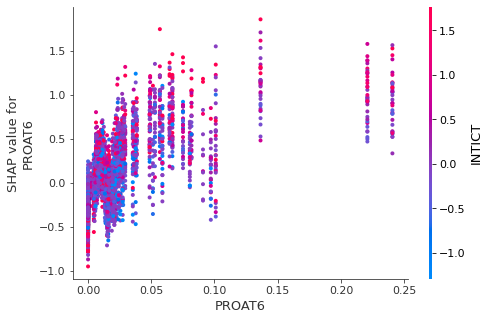

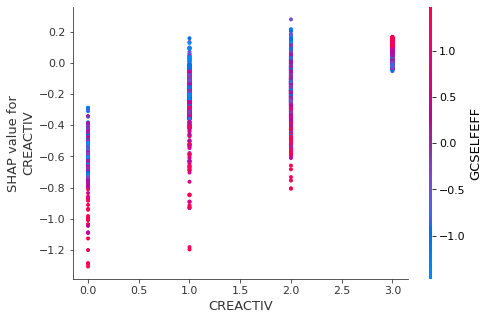

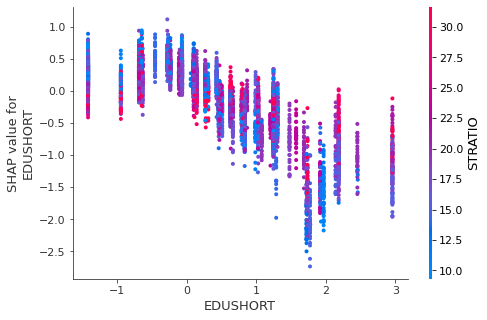

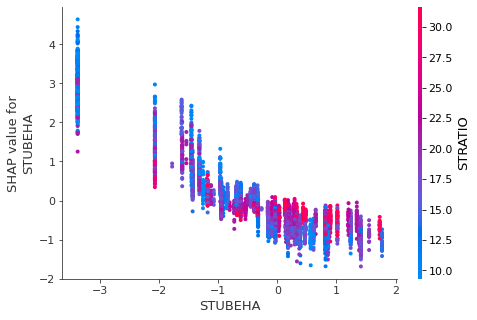

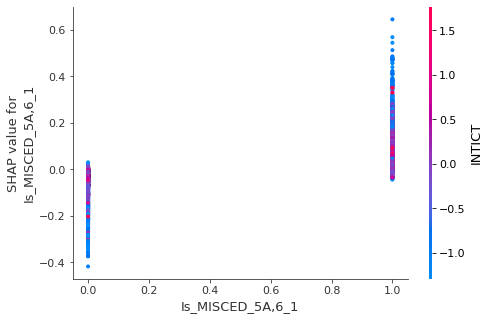

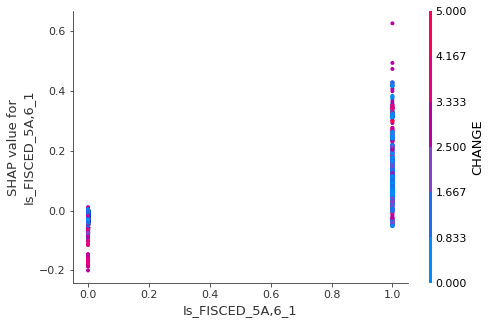

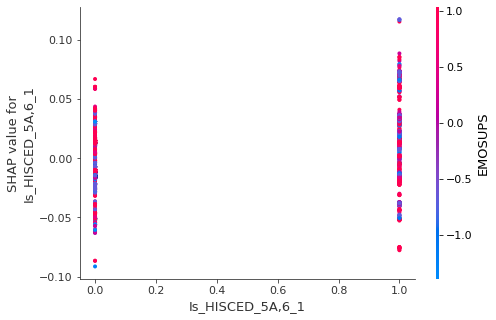

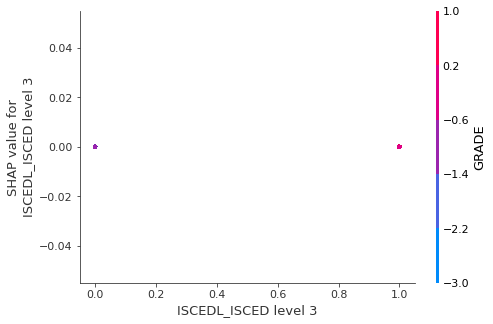

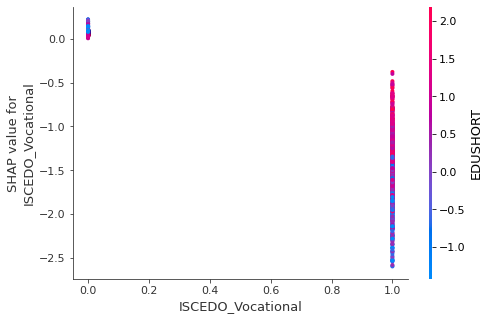

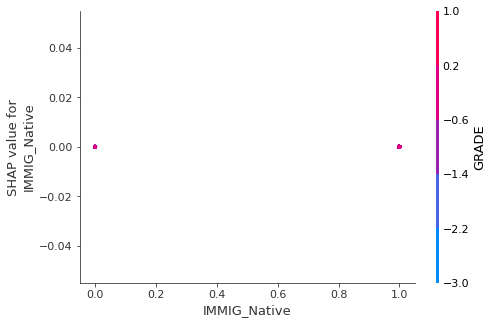

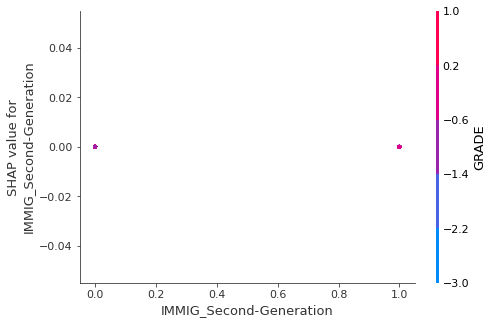

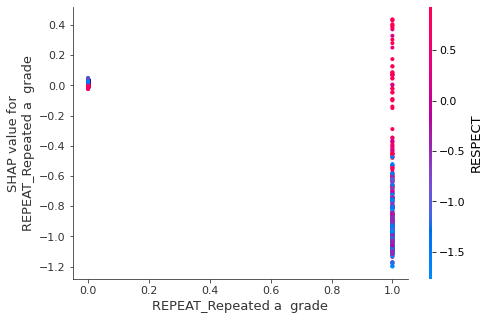

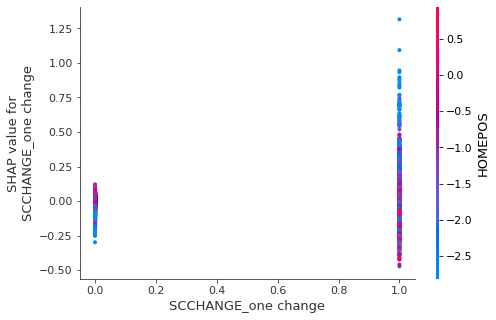

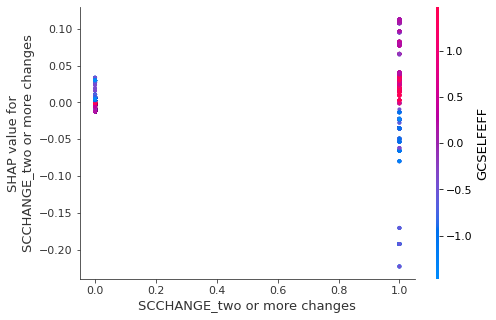

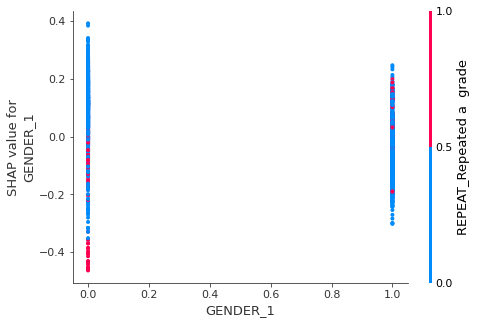

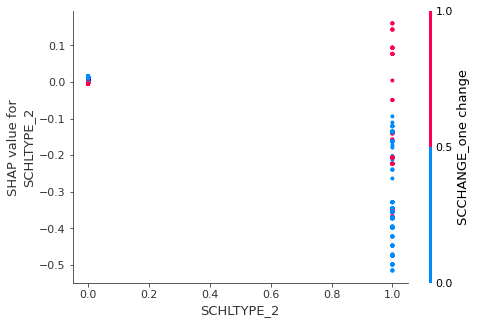

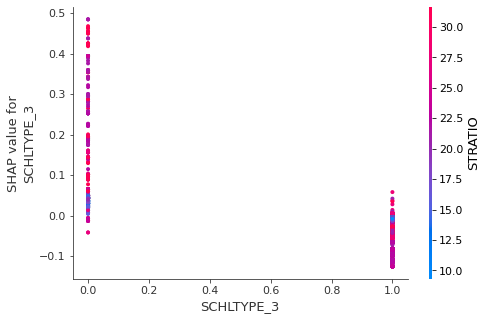

In [51]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)